In [ ]:
"""
count seems to decrease score
full interactions seems too much

features, shape, iter, cv, public

"""

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import xgboost as xgb
import vw_utils as vw
import gini
%matplotlib inline

In [256]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train['train_set'] = 1
test['train_set'] = 0

data = pd.concat([train, test], axis=0).reset_index()

(50999, 35)

## --------------------- Feature Start -----------------------

In [198]:
# start
categorical = ['T1_V' + str(i) for i in list(range(4, 10)) + [11, 12, 15, 16, 17]] + \
                ['T2_V' + str(i) for i in [3, 5, 11, 12, 13]]

numerical = set(train.columns).difference(categorical + ['Hazard', 'Id'])
numerical = list(numerical)

In [273]:
# raw feature
from sklearn.preprocessing import StandardScaler
import re

SS = StandardScaler()
feat_raw = data[numerical]
feat_raw[numerical] = SS.fit_transform(feat_raw[numerical])


toDrop = re.sub('[ ]+', '_', data[categorical].ix[0, :].to_string()).split('\n')
feat_raw_2 = pd.get_dummies(data[categorical]).drop(toDrop, axis=1)

feat_raw = pd.concat([feat_raw, feat_raw_2], axis=1)
feat_raw.shape

/home/albertium/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))
/home/albertium/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/albertium/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(101999, 96)

In [263]:
%%time
# sofia feature
from sofia_utils import sofia_kmeans

DV = DictVectorizer(sparse=False)

n_clusters = 10

sofia = sofia_kmeans(n_clusters=n_clusters, iterations=1000, mapping_threshold=0.0001)

feat_sofia = sofia.fit_transform(feat_raw)

feature_names = ['sofia_'+str(i+1) for i in range(n_clusters)]
feat_sofia = pd.DataFrame(feat_sofia, columns=feature_names)
feat_sofia

extract percent:  8741540.0
sparcity:  0.999898038216
CPU times: user 11.1 s, sys: 628 ms, total: 11.7 s
Wall time: 16.6 s


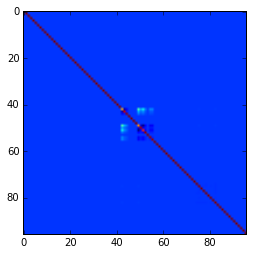

In [282]:
from sofia_utils import Whitener

whitener = Whitener()
tmp = whitener.fit_transform(feat_raw)
plt.imshow(np.cov(tmp.T))

In [155]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
feat_sofia_train.ix[:, :] = MMS.fit_transform(feat_sofia_train.values)
feat_sofia_test.ix[:, :] = MMS.transform(feat_sofia_test.values)

In [156]:
%%time
from sklearn.feature_extraction import DictVectorizer

feat_train = pd.concat([feat_raw_train, feat_sofia_train], axis=1)
feat_test = pd.concat([feat_raw_test, feat_sofia_test], axis=1)

DV = DictVectorizer(sparse=False)
train_c = DV.fit_transform(feat_train.T.to_dict().values())
test_c = DV.transform(feat_test.T.to_dict().values())

print(train_c.shape)

(50999, 311)
CPU times: user 24.4 s, sys: 636 ms, total: 25 s
Wall time: 25 s


## --------------------- Feature End -----------------------

In [157]:
%%time
# with sofia: 0.32307
# with 50 sofia: 0.32745
# with 100 sofia: 
# base: 0.32529
from sklearn.linear_model import SGDRegressor
from sklearn.cross_validation import cross_val_score
import gini
from sklearn.metrics import mean_squared_error

regressor = SGDRegressor(loss='squared_loss', penalty='l1', alpha=1E-3, n_iter=10)
scores = cross_val_score(regressor, train_c, train.Hazard.values, cv=20, scoring=gini.normalized_gini_score)
print(scores.mean())

0.328059944617
CPU times: user 24.6 s, sys: 136 ms, total: 24.7 s
Wall time: 24.7 s


In [103]:
%%time
# 0.36597
# with sofia: 0.36420
# base: 0.36906
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

RFR = RandomForestRegressor(n_estimators=1000, max_features='sqrt', min_samples_leaf=5, oob_score=True, n_jobs=-1)
scores = cross_val_score(RFR, train_c, train.Hazard.values, cv=10, scoring=gini.normalized_gini_score, n_jobs=-1)
print(scores.mean())

0.369066286897
CPU times: user 1.72 s, sys: 736 ms, total: 2.46 s
Wall time: 9min 1s


In [77]:
model = 'linear1'
yhat = np.loadtxt('../tmp/{}/out'.format(model))
pd.DataFrame({'Id': ID, 'Hazard': yhat}).reindex_axis(['Id', 'Hazard'], 1).to_csv('../output/lin01.csv', index=0)

## --------------------- Factory -----------------------

In [6]:
%%time
from sklearn.preprocessing import PolynomialFeatures

PF = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_c = PF.fit_transform(train_c)
print(train_c.shape)

(50999, 6216)
CPU times: user 6.03 s, sys: 2.56 s, total: 8.59 s
Wall time: 8.59 s


In [75]:
%%time
# kmeans features

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()

kmeans = KMeans(80, random_state=12345, n_init=1)
feat_kmeans_train = kmeans.fit_transform(SS.fit_transform(train[numerical]))
feat_kmeans_test = kmeans.transform(SS.transform(test[numerical]))

# print('variance lost:')
# print(kmeans.inertia_ / KMeans(1, random_state=12345, n_init=1).fit(train[numerical]).inertia_)

feat_kmeans_train = pd.DataFrame(feat_kmeans_train).add_prefix('kmeans_')
feat_kmeans_test = pd.DataFrame(feat_kmeans_test).add_prefix('kmeans_')

numerical += feat_kmeans_train.columns.values.tolist()
train_c = pd.concat([train_c, feat_kmeans_train], axis=1)
test_c = pd.concat([test_c, feat_kmeans_test], axis=1)

CPU times: user 14.5 s, sys: 4 ms, total: 14.5 s
Wall time: 14.5 s


/home/albertium/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [49]:
# count features

feat_count_train = train[categorical].copy()
feat_count_test = test[categorical].copy()

for cat in categorical:
    numerical.append('cnt_'+cat)
    hotDeck = train[cat].value_counts().reset_index().rename(columns={'index': cat, 0: 'cnt_'+cat})
    feat_count_train = pd.merge(feat_count_train, hotDeck, on=cat)
    del feat_count_train[cat]
    
    feat_count_test = pd.merge(feat_count_test, hotDeck, on=cat)
    del feat_count_test[cat]
    
train_c = pd.concat([train_c, feat_count_train], axis=1)
test_c = pd.concat([test_c, feat_count_test], axis=1)

In [53]:
# categorical encoding
from sklearn.preprocessing import StandardScaler

feat_encode_train = train[categorical].copy()
feat_encode_test = test[categorical].copy()

for cat in categorical:
    hot_deck = train.groupby(cat).Hazard.mean().reset_index().rename(columns={'Hazard': 'encode_'+cat})
    feat_encode_train = pd.merge(feat_encode_train, hot_deck, on=cat)
    del feat_encode_train[cat]
    
    feat_encode_test = pd.merge(feat_encode_test, hot_deck, on=cat)
    del feat_encode_test[cat]
    
names = feat_encode_train.columns
ss = StandardScaler()
feat_encode_train[names] = ss.fit_transform(feat_encode_train.values)
feat_encode_test[names] = ss.transform(feat_encode_test.values)

encode_T1_V4     1.011131
encode_T1_V5     1.003089
encode_T1_V6     0.999460
encode_T1_V7     1.025445
encode_T1_V8     0.985815
encode_T1_V9     1.000703
encode_T1_V11    1.001235
encode_T1_V12    0.987670
encode_T1_V15    1.007230
encode_T1_V16    1.005126
encode_T1_V17    1.003132
encode_T2_V3     0.998128
encode_T2_V5     1.001219
encode_T2_V11    1.002282
encode_T2_V12    1.004119
encode_T2_V13    0.994556
dtype: float64

In [81]:
%%time
# reduce
from xgboost import XGBRegressor
import xgboost as xgb

feat_reduce_train = pd.DataFrame()
feat_reduce_test = pd.DataFrame()

for num in numerical:
    dTmp = xgb.DMatrix(train[[num]], label=train.Hazard)
    reg = xgb.train({'max_depth':8, 'min_child_weight':30, 'objective':'reg:linear'}, dTmp, 1)
    
    feat_reduce_train['discrete_'+num] = reg.predict(dTmp, pred_leaf=True)
    feat_reduce_train['discrete_'+num] = feat_reduce_train['discrete_'+num].map(str)
    
    feat_reduce_test['discrete_'+num] = reg.predict(xgb.DMatrix(test[[num]]), pred_leaf=True)
    feat_reduce_test['discrete_'+num] = feat_reduce_test['discrete_'+num].map(str)

Wall time: 6.86 s


In [73]:
# discrete

feat_discrete_train = train[numerical].applymap(str)
feat_discrete_test = test[numerical].applymap(str)

In [88]:
# combine all features
cTrain = train[numerical+categorical]
cTest = test[numerical+categorical]

# cTrain = pd.concat([train[numerical+categorical], feat_reduce_train], axis=1)
# cTest = pd.concat([test[numerical+categorical], feat_reduce_test], axis=1)